### Importing required libraries

In [1]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.decomposition import PCA

### Utilities 

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [3]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [3]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 435


### gF score distribution

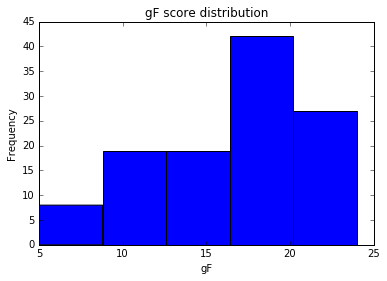

5

In [4]:
# gF score distribution 
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 



In [5]:
# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits)
print(bin_limits)

[  5.    8.8  12.6  16.4  20.2  24. ]


### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

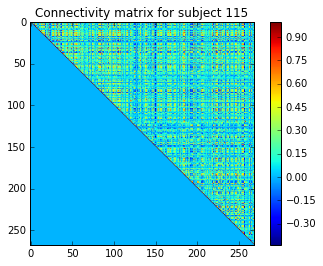

In [6]:
# choose dataset
conn_mats = data['rest_1_mat']
#conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Training/Test Split
In order to build an holdout set that preserves the distribution of the gF scores across subjects, the scores are divided in bins and then a stratified split is performed.  

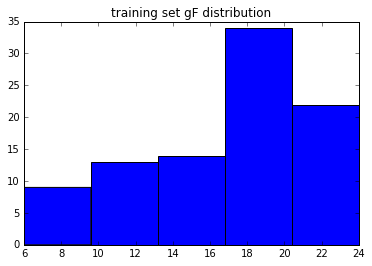

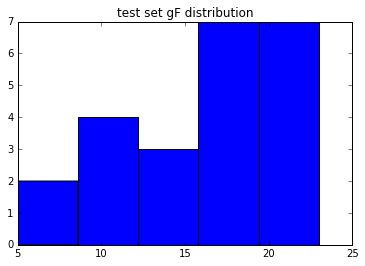

In [7]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

### Test 1: Elastic Net
A cross validation loop in used to select the best parameters for a linear regression model based on elastic net. The generalization ability of the model is assessed on the test set.

In [13]:
# Test with all edges and parameter selection by cross validation
k=5
n_bins_cv = 5
hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
bins_cv = np.digitize(y_train, bin_limits_cv)
cv = cross_validation.StratifiedKFold(bins_cv,k)
elnet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],cv=cv,verbose=True,n_jobs=-1)
elnet.fit(X_train,y_train)
predictions = elnet.predict(X_test)
preds_1 = predictions

C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................C:\Users\paola\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. Y

In [14]:
print(elnet.alpha_)
print(elnet.l1_ratio_)

0.164989265676
0.7


### Test 2: Lasso

In [10]:
# Test with all edges and parameter selection by cross validation
k=5
n_bins_cv = 5
hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
bins_cv = np.digitize(y_train, bin_limits_cv)
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,verbose=True,n_jobs=-1)
lasso.fit(X_train,y_train)
predictions = lasso.predict(X_test)
print(predictions)
preds_2 = predictions

C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


[ 16.97984076  17.14711823  13.91449739  18.05201264  17.04350848
  15.85750566  18.93929224  19.37753415  17.47309007  18.14293679
  17.37464082  14.46423333  16.03731851  15.64965985  14.73883955
  16.26342609  16.78054484  14.871581    15.83434376  15.90270834
  15.88295982  16.21543091  16.89580789]


In [11]:
print(lasso.alpha_)

0.163707614879


In [17]:
results = {'res_elasticnet':preds_1,'res_lasso':preds_2, 'score':y_test}
sio.savemat('res_elasticnet.mat', results)

### Plots

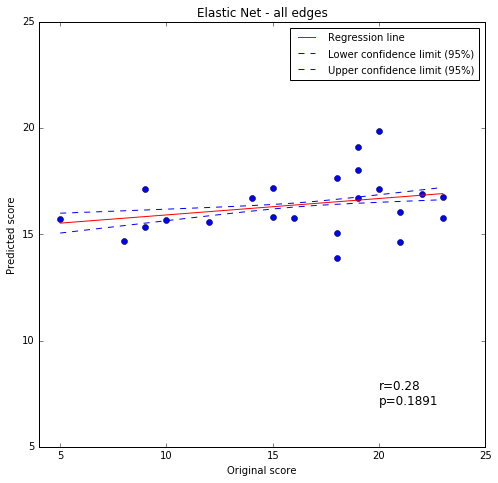

In [15]:
regression_plot(np.ravel(y_test),np.ravel(preds_1),n_subj,'Elastic Net - all edges') 

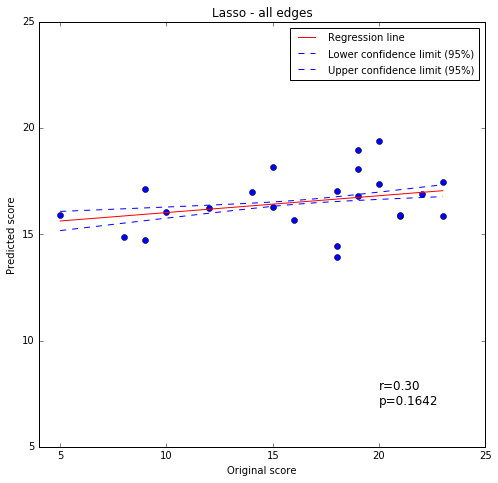

In [16]:
regression_plot(np.ravel(y_test),np.ravel(preds_2),n_subj,'Lasso - all edges') 